In [158]:
import string

import pandas as pd
import seaborn as sns

from nltk.corpus import stopwords
from nltk.stem import PorterStemmer
from nltk.tokenize import word_tokenize

from sklearn.model_selection import train_test_split, cross_val_score
from sklearn.metrics import f1_score
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.svm import LinearSVC
from sklearn.cluster import KMeans
from sklearn.manifold import TSNE

In [159]:
seed = 42

# Data preparation

In [ ]:
def clean_df(df):
    return df

def clean_text(text: str):
    # remove punctuation
    text = text.translate(str.maketrans("", "", string.punctuation))

    tokens = word_tokenize(text)

    # remove stopwords + digits
    stop_words = set(stopwords.words("english"))
    tokens = [word for word in tokens if word not in stop_words and not str.isdigit(word)]

    # stemming
    stemmer = PorterStemmer()
    tokens = [stemmer.stem(word) for word in tokens]

    return ' '.join(tokens)

def prep_features(df: pd.DataFrame, for_unsupervised: bool):
    df = df.drop(["ID"], axis=1)

    # basic cleaning
    df["text"] = df["text"].apply(lambda s: s.lower().strip())

    if for_unsupervised:
        df["text"] = df["text"].apply(clean_text)
        return df["text"]
    
    if "label" in df:
        return df["text"], df["label"]
    return df["text"]

In [161]:
df = pd.read_csv("train_data.csv")
df = clean_df(df)

X_supervised, y_supervised = prep_features(df, for_unsupervised=False)

In [162]:
X_supervised.head()

0    in "tie challenge of exploring venus," tie aut...
1    these sources focus on the advantages of limit...
2    this new technology can really figure out if y...
3    in today's society, technology is used everyda...
4    limiting car usage is a topic that has been ga...
Name: text, dtype: object

# Model selection - subtask 1

In [163]:
X_train, X_test, y_train, y_test = train_test_split(X_supervised, y_supervised, test_size=0.33, random_state=seed)

In [164]:
sup_vectorizer = TfidfVectorizer(min_df=2, max_df=0.95, analyzer='char_wb', ngram_range=(2, 8))

X_train = sup_vectorizer.fit_transform(X_train)
X_test = sup_vectorizer.transform(X_test)

In [165]:
def evaluate(clf):
    cv = cross_val_score(clf, X_train, y_train, cv=3, n_jobs=-1)
    cv_score = cv.mean() - cv.std()

    clf.fit(X_train, y_train)
    score = f1_score(y_test, clf.predict(X_test))
    return cv_score, score

In [166]:
svc = LinearSVC()

evaluate(svc)

(0.9565778869570017, 0.9346271705822268)

In [167]:
clf = svc
clf.fit(X_train, y_train)

LinearSVC()

# Clustering - subtask 2

In [168]:
df_test = pd.read_csv("test_data.csv")
df_test = clean_df(df_test)

df_test_2 = df_test[df_test["subtaskID"] == 2].copy()
X_unsupervised = prep_features(df_test_2, for_unsupervised=True)

In [169]:
vectorizer = TfidfVectorizer(min_df=5, max_df=0.8, stop_words='english')

X = vectorizer.fit_transform(X_unsupervised)

In [170]:
km = KMeans(4, n_init=100, random_state=seed)
df_test_2["cluster"] = km.fit_predict(X)

<Axes: xlabel='tsne_x', ylabel='tsne_y'>

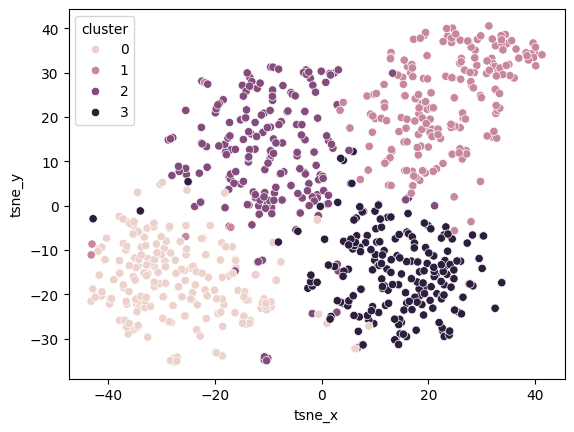

In [171]:
X_embedded = TSNE(n_components=2, init='random').fit_transform(X)

df_test_2["tsne_x"] = X_embedded[:, 0]
df_test_2["tsne_y"] = X_embedded[:, 1]

sns.scatterplot(x="tsne_x", y="tsne_y", hue="cluster", data=df_test_2)

In [172]:
# print out samples from each cluster, to label them
terms = vectorizer.get_feature_names_out()
centroids = km.cluster_centers_
for cluster_idx in range(4):
    top_terms_idx = centroids[cluster_idx].argsort()[::-1][:10]

    top_terms = [terms[i] for i in top_terms_idx]
    print(f"cluster {cluster_idx}: {', '.join(top_terms)}")

cluster 0: polic, said, shoot, offic, school, charg, told, investig, suspect, victim
cluster 1: scientist, scienc, research, space, nasa, earth, planet, climat, moon, said
cluster 2: compani, uber, busi, said, percent, women, employe, amazon, work, market
cluster 3: god, church, christian, religi, peopl, jesu, muslim, white, faith, trump


In [173]:
df_test_2["topic"] = df_test_2["cluster"].map({
    0: "CRIME",
    1: "SCIENCE",
    2: "BUSINESS",
    3: "RELIGION",
})

# Submission

In [177]:
# subtask 1
df_test_1 = df_test[df_test["subtaskID"] == 1]

features = prep_features(df_test_1, for_unsupervised=False)
features = sup_vectorizer.transform(features)

subtask1 = clf.predict(features)

# subtask 2
subtask2 = df_test_2["topic"]

In [178]:
def build_subtask(id, answer):
    df = df_test_1 if id == 1 else df_test_2
    return pd.DataFrame({
        "subtaskID": id, "datapointID": df["ID"], "answer": answer
    })

subtasks = [
    (1, subtask1),
    (2, subtask2)
]

submission = pd.concat([build_subtask(sid, subtask) for sid, subtask in subtasks], ignore_index=True)

In [179]:
submission.head()

,subtaskID,datapointID,answer
0,1,10001,1.0
1,1,10002,0.0
2,1,10003,1.0
3,1,10004,0.0
4,1,10005,1.0


In [180]:
submission.to_csv("submission.csv", index=False)